# Predicting daily bikerider count from temperature and weekday

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

import pymc3 as pm
import arviz as az

import scipy.stats as stats

## Import data

We import a dataset that contains the daily number of bike riders at a counting station in Freiburg (channel name: 'FR1 Dreisam / Hindenburgstr.') in 2021 as well as the daily average temperature and a boolean whether a given day is a business day.

In [2]:
# import data
combined_daily_dat = pd.read_pickle('./../data/processed/combined_daily_dat.pkl')

# counting station
city_name = 'Stadt Freiburg'
counter_site = 'FR1 Dreisam / Otto-Wels-Str.'
channel_name = 'FR1 Dreisam / Hindenburgstr.'

# extract data for counting station
combined_daily_dat = combined_daily_dat[(combined_daily_dat.standort == city_name) & (combined_daily_dat.counter_site == counter_site) & (combined_daily_dat.channel_name == channel_name)]

In [3]:
# inspect
combined_daily_dat

,standort,counter_site,channel_name,longitude,latitude,date,temperature,is_busday,rider_count
0,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-01,1.4,True,521
1,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-02,0.8,False,1131
2,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-03,-0.5,False,764
3,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-04,0.0,True,1607
4,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-05,-0.7,True,1668
...,...,...,...,...,...,...,...,...,...
348,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-12-26,6.3,False,482
349,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-12-27,7.0,True,1395
350,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-12-28,10.0,True,1357
351,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-12-29,9.7,True,1299


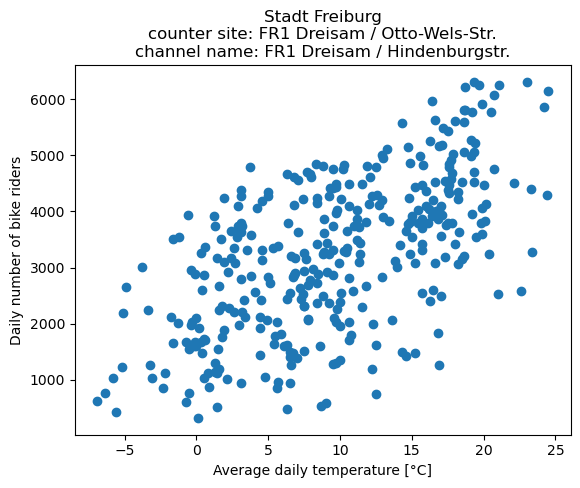

In [4]:
# plot daily bikerider count by mean day temperature
plt.scatter(combined_daily_dat['temperature'], combined_daily_dat['rider_count'])
plt.xlabel('Average daily temperature [°C]')
plt.ylabel('Daily number of bike riders')
plt.title(city_name + '\ncounter site: ' + counter_site + '\nchannel name: ' + channel_name);

In [5]:
def plot_data(data=combined_daily_dat):
    '''
    Plot daily bikerider count by mean day temperature, separate between business days and weekends.

    Parameters
    ----------
    data pd.DataFrame
        Dataframe with columns 'temperature', 'is_busday' and 'rider_count'.

    Returns
    -------
    (plot)
    '''
    # plot data
    plt.scatter(data[data['is_busday'] == True]['temperature'], data[data['is_busday'] == True]['rider_count'], label='business day', color='orange')
    plt.scatter(data[data['is_busday'] == False]['temperature'], data[data['is_busday'] == False]['rider_count'], label='weekend', color='blue')

    # legend
    plt.xlabel('Average daily temperature [°C]')
    plt.ylabel('Daily number of bike riders')
    plt.legend();

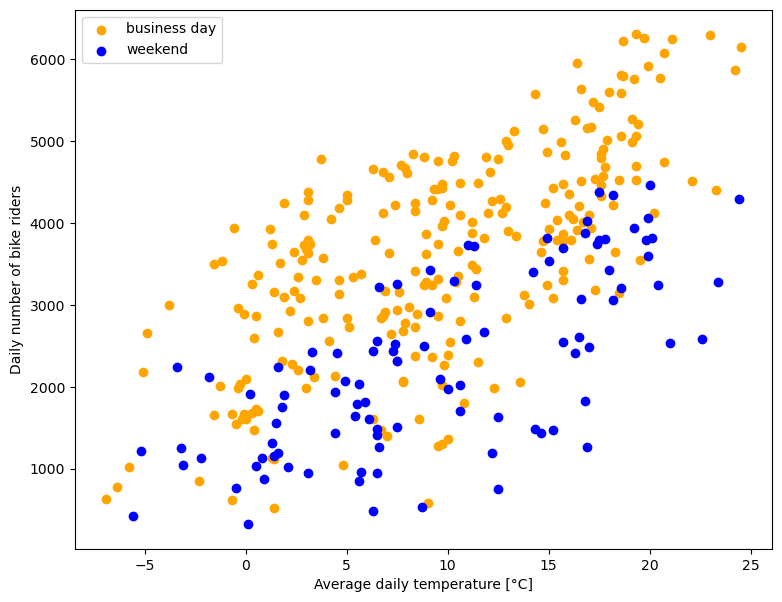

In [6]:
# plot daily bikerider count by mean day temperature, separate between business days and weekends
plt.figure(figsize=(9,7))
plot_data()

Define utility functions to plot the data with model fits later on:

In [7]:
def plot_linear_fit(intercept, slope, intercept_business_days, slope_interaction, label_non_busday_fit=None, label_busday_fit=None, alpha=1):
    # TODO kommentieren

    # plot fit
    x_temps = np.linspace(-5, 25, 10)
    plt.plot(x_temps, intercept +  x_temps * slope, label=label_non_busday_fit, color='blue', alpha=alpha)
    plt.plot(x_temps, intercept + intercept_business_days +  x_temps * (slope + slope_interaction), label=label_busday_fit, color='orange', alpha=alpha)
    plt.legend();

In [8]:
def plot_exponential_fit(intercept, slope, intercept_business_days, slope_interaction, label_non_busday_fit=None, label_busday_fit=None, alpha=1):
    # TODO kommentieren

    # plot fit
    x_temps = np.linspace(-5, 25, 10)
    plt.plot(x_temps, np.exp(intercept +  x_temps * slope), label=label_non_busday_fit, color='blue', alpha=alpha)
    plt.plot(x_temps, np.exp(intercept + intercept_business_days +  x_temps * (slope + slope_interaction)), label=label_busday_fit, color='orange', alpha=alpha)
    plt.legend();

In [9]:
def plot_data_and_fit(intercept, slope, intercept_business_days, slope_interaction, plot_fun_fit, is_bayes=False):
    '''
    Plot data and fit. Fitted function has the given parameter values
    (intercept, ...) and the form defined by plot_fun_fit.
    TODO besser kommentieren

    Parameters
    ----------
    intercept : number
        Intercept of the regression line for non-business days.
    slope : number
        Slope of the regression line for non-business days.
    intercept_business_days : number
        Additional intercept of the regression line for business days.
    slope_interaction : number
        Additional slope of the regression line for business days.
    plot_fun_fit : function
        Function to use for plotting the fitted regression lines.
        Either plot_linear_fit or plot_exponential_fit.
    is_bayes : boolean
        TODO whether fit derived from Bayes...
    
    Returns
    -------
    (plot)
    '''
    # plot data
    plot_data()

    # adjust labels
    if (is_bayes):
        label_busday_fit = 'busday mean posterior'
        label_non_busday_fit = 'non_busday mean posterior'
    else:
        label_busday_fit = 'busday_fit'
        label_non_busday_fit = 'non_busday_fit'

    # plot fit
    plot_fun_fit(intercept, slope, intercept_business_days, slope_interaction, label_non_busday_fit=label_non_busday_fit, label_busday_fit=label_busday_fit)

In [10]:
def plot_data_and_linear_fit(intercept, slope, intercept_business_days, slope_interaction, is_bayes=False):
    # TODO kommentieren

    plot_data_and_fit(intercept, slope, intercept_business_days, slope_interaction, plot_linear_fit, is_bayes)

In [11]:
def plot_data_and_exponential_fit(intercept, slope, intercept_business_days, slope_interaction, is_bayes=False):
    # TODO kommentieren
    
    plot_data_and_fit(intercept, slope, intercept_business_days, slope_interaction, plot_exponential_fit, is_bayes)

## Statistical Analysis

### Linear Regression: Gaussian model with identity link function

#### Frequentist

In [12]:
# fit linear Gaussian model to the daily bike rider counts data,
# predictors: mean day temperature and being a business day

fit_daily_counts = smf.glm(
    formula='rider_count ~ temperature * is_busday',
    data=combined_daily_dat).fit()

# check the fit result
print(fit_daily_counts.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            rider_count   No. Observations:                  353
Model:                            GLM   Df Residuals:                      349
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                      8.1123e+05
Method:                          IRLS   Log-Likelihood:                -2900.4
Date:                Sat, 07 Jan 2023   Deviance:                   2.8312e+08
Time:                        15:01:29   Pearson chi2:                 2.83e+08
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7273
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

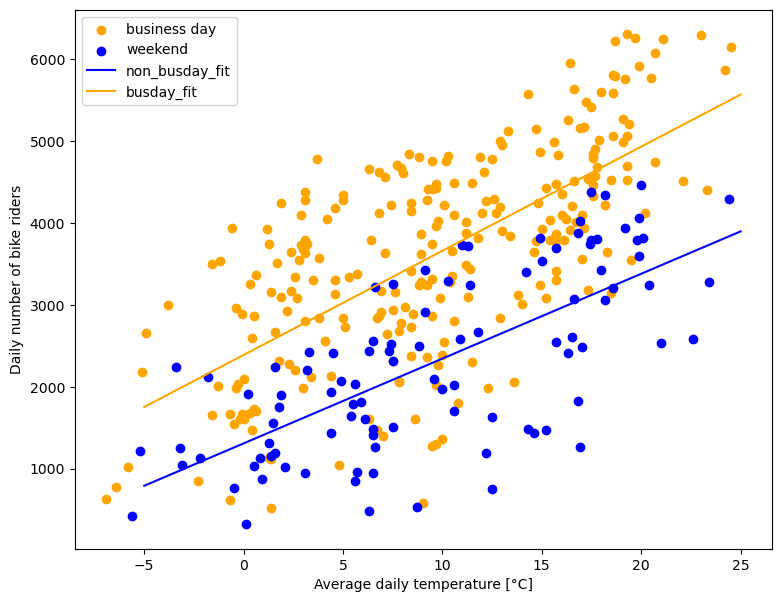

In [13]:
plt.figure(figsize=(9,7))
plot_data_and_linear_fit(
    fit_daily_counts.params['Intercept'],
    fit_daily_counts.params['temperature'],
    fit_daily_counts.params['is_busday[T.True]'],
    fit_daily_counts.params['temperature:is_busday[T.True]']
)

##### Check some of the model assumptions

Normal distribution of residuals?

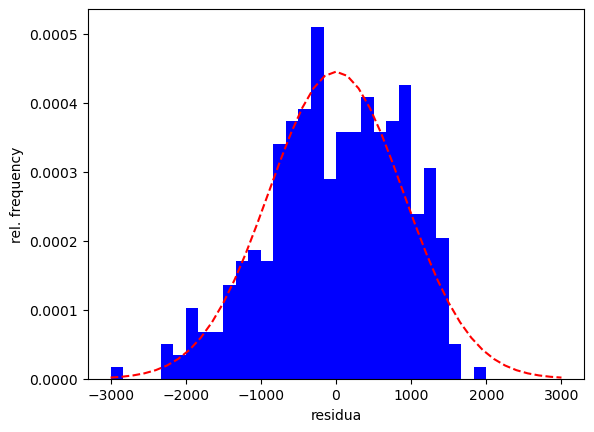

In [14]:
# inspect residuals
bins=np.linspace(-3000., 3000., 37)
x = np.linspace(-3000., 3000., 41)

# plot residuals
plt.hist(fit_daily_counts.resid_response, bins, color='b', density=True)

# estimate Gaussian distribution for residuals
mu, sigma = (fit_daily_counts.resid_response.mean(), fit_daily_counts.resid_response.std())
plt.plot(x, stats.norm(mu, sigma).pdf(x), 'r--')

# labels
plt.xlabel('residua')
plt.ylabel('rel. frequency');

TODO Schon ein bisschen verschoben, oder? Rechts eher mehr, links eher weniger...
Und links im Rand mehr als rechts.

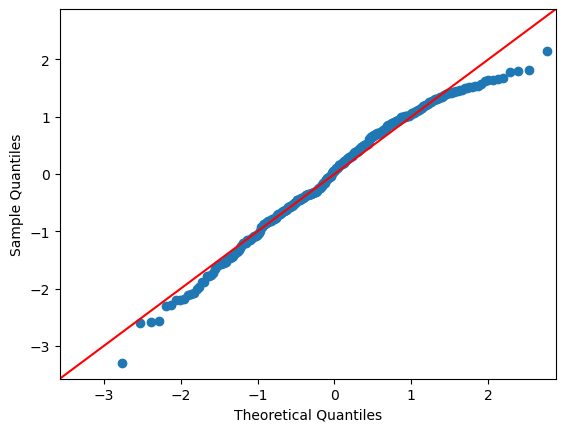

In [15]:
# TODO Stimmt Funktion?
fig = sm.qqplot(fit_daily_counts.resid_response, stats.t, fit=True, line="45")
plt.show()

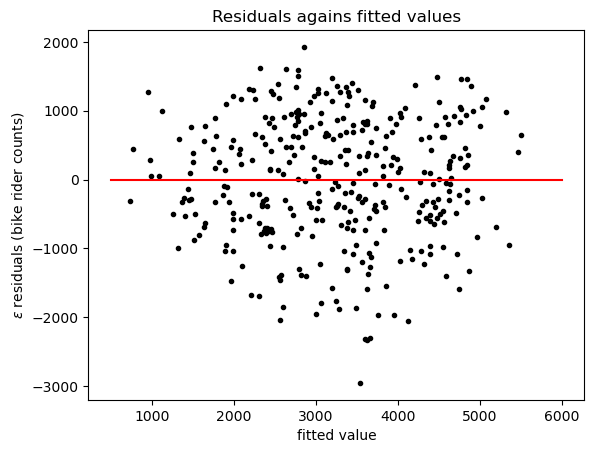

In [16]:
# TODO inspect residuals: residuals vs fits
# equal vairance?
# See also: https://online.stat.psu.edu/stat462/node/117/

plt.plot(fit_daily_counts.predict(combined_daily_dat), fit_daily_counts.resid_response, 'k.')
plt.plot([500, 6000], 2*[0], 'r-')
plt.xlabel('fitted value')
plt.ylabel('$\epsilon$ residuals (bike rider counts)')
plt.title('Residuals agains fitted values');

#### Same same but different: Again, "Linear Regression: Gaussian model with identity link function", Frequentist, but with "smf.ols" to get more summary data

In [17]:
# try different fit method to get more summary data
fit_daily_counts_ols = smf.ols(formula="rider_count ~ temperature * is_busday", data=combined_daily_dat).fit()
print(fit_daily_counts_ols.summary())

                            OLS Regression Results                            
Dep. Variable:            rider_count   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     152.9
Date:                Sat, 07 Jan 2023   Prob (F-statistic):           2.92e-63
Time:                        15:01:29   Log-Likelihood:                -2900.4
No. Observations:                 353   AIC:                             5809.
Df Residuals:                     349   BIC:                             5824.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

#### Bayes

Utility functions for showing the results:

In [18]:
# plot data, MAP fit and example posteriors
def show_data_MAP_and_posts(model, plot_fun_fit):
    '''
    Plot data, MAP and example posteriors.
    # TODO besser formulieren / kommentieren

    Parameters
    ----------
    model : pm.Model()
        model... TODO
    plot_fun_fit
        Function to use for plotting the fitted regression lines.
        Either plot_linear_fit or plot_exponential_fit.
    '''
    # extract betas
    with model:
        postbetas_intercept = trace["beta_intercept"]
        postbetas_slope = trace["beta_slope"]
        postbetas_intercept_business_days = trace["beta_intercept_business_days"]
        postbetas_slope_interaction = trace["beta_slope_interaction"]
    
    # initialize figure
    plt.figure(figsize=(9,7))

    # plot some posteriors as examples # TODO gibt es da Funktion für?

    num_posts_to_plot = 40 # number of posteriors to plot # TODO Benennung richtig? samples?

    # draw random indices (--> random examples)
    with model:
        rand_indices = np.random.choice(a=len(postbetas_intercept), size=num_posts_to_plot, replace=False)

    # plot example posteriors # TODO Benennung richtig? samples?
    for i, idx in enumerate(rand_indices):

        # temperature range
        x_temps = np.linspace(-10, 30, 10) # TODO adjust range

        if (i == 0): # add label for first plotted posterior
            plot_fun_fit(postbetas_intercept[idx], postbetas_slope[idx], postbetas_intercept_business_days[idx], postbetas_slope_interaction[idx], 'non_busday posteriors', 'busday posteriors', alpha=0.3)
        else:
            # TODO adjust alpha
            plot_fun_fit(postbetas_intercept[idx], postbetas_slope[idx], postbetas_intercept_business_days[idx], postbetas_slope_interaction[idx], alpha=0.3)
    
    # plot data and MAP
    plot_data_and_fit(postbetas_intercept.mean(),
             postbetas_slope.mean(),
             postbetas_intercept_business_days.mean(),
             postbetas_slope_interaction.mean(),
             plot_fun_fit,
             True)

In [19]:
def show_results(model, plot_fun_fit):
    '''
    Print and plot fit results.
    '''
    # show results
    with model:
        pm.plot_trace(trace)
        display(az.summary(trace, hdi_prob=0.95))

    with model:
        ax = az.plot_posterior(trace, var_names=['beta_intercept', 'beta_slope', 'beta_intercept_business_days', 'beta_slope_interaction'], hdi_prob=0.95)
    
    # plot data, MAP and example posteriors
    show_data_MAP_and_posts(model, plot_fun_fit)

In [20]:
def show_results_linear_fit(model):
    '''
    Print and plot fit results for linear fit.
    '''
    show_results(model, plot_linear_fit)

In [21]:
def show_results_exponential_fit(model):
    '''
    Print and plot fit results for exponential fit.
    '''
    show_results(model, plot_exponential_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_slope_interaction, beta_intercept_business_days, beta_slope, beta_intercept]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 10 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_intercept[0],1311.598,123.545,1068.277,1547.932,2.261,1.600,2989.0,4061.0,1.0
beta_slope[0],103.129,10.408,83.631,124.270,0.192,0.136,2941.0,3851.0,1.0
beta_intercept_business_days[0],1070.221,158.291,769.648,1384.297,2.981,2.123,2826.0,4125.0,1.0
beta_slope_interaction[0],24.539,13.270,-2.594,49.011,0.254,0.179,2734.0,4323.0,1.0
sigma[0],762.111,52.396,667.214,870.380,0.657,0.467,6422.0,5186.0,1.0
sigma[1],929.625,40.942,854.047,1009.737,0.525,0.372,6062.0,5483.0,1.0


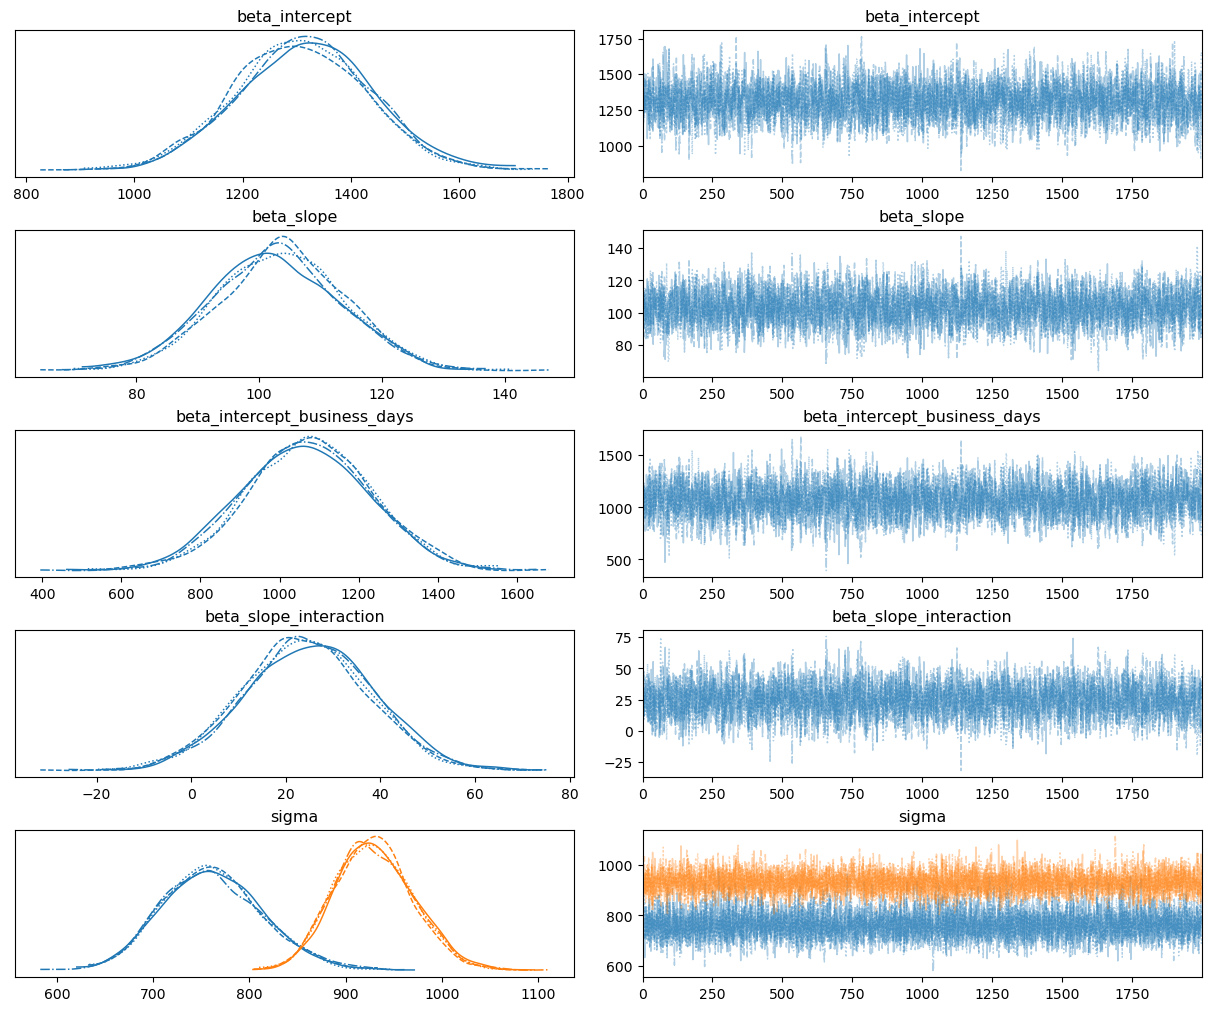

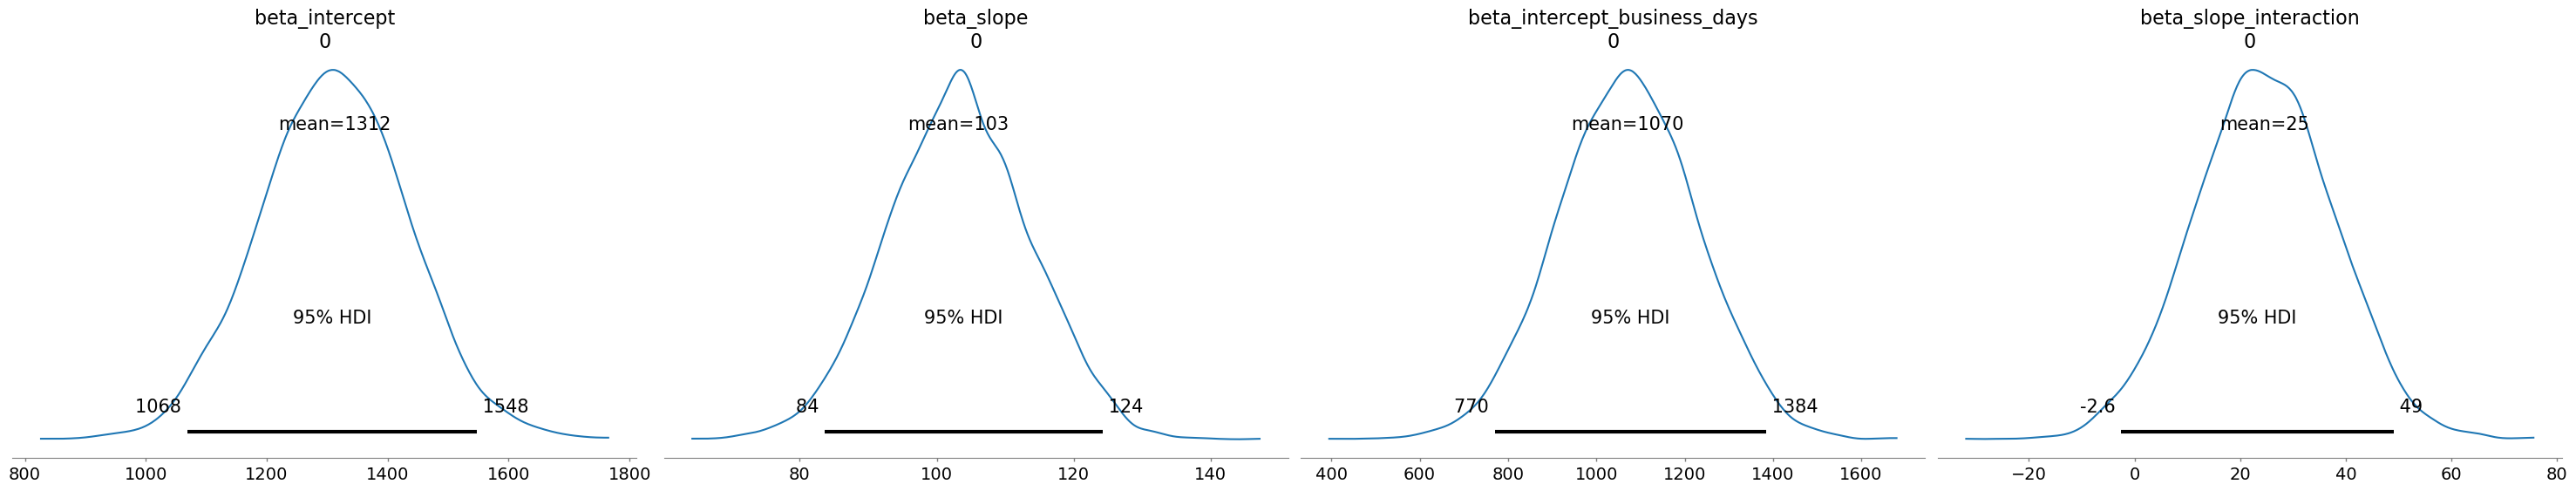

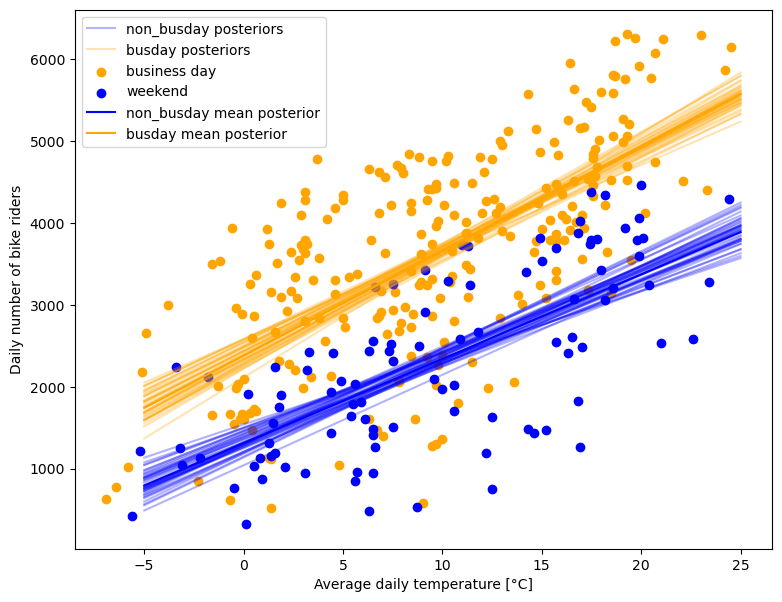

In [22]:
# build linear model with categories "business-day vs no-business-day"
with pm.Model() as linearCategoricalModel:

    dat_temps = dat = pm.Data('dat_temps', combined_daily_dat[['temperature']])
    dat_busday = dat = pm.Data('dat_busday', combined_daily_dat[['is_busday']])
    dat_rider_counts = dat = pm.Data('dat_rider_counts', combined_daily_dat[['rider_count']])
    
    # TODO prior anpassen
    # prior for parameters beta
    # idea: same parametrization as in Frequentist analysis above.
    # TODO Keep in mind: Prior should reflect prior knowledge; not expectation.
    beta_intercept = pm.Normal("beta_intercept", mu=0, sigma=1000, shape=1)
    beta_slope = pm.Normal("beta_slope", mu=0, sigma=100, shape=1)
    beta_intercept_business_days = pm.Normal("beta_intercept_business_days", mu=0, sigma=1000, shape=1)
    beta_slope_interaction = pm.Normal("beta_slope_interaction", mu=0, sigma=100, shape=1)
    
    # prior for two noise distributions: better small
    sigma = pm.Exponential("sigma", lam=.01, shape=2)
    
    # the linear model function
    expected = beta_intercept + beta_slope * dat_temps + beta_intercept_business_days * dat_busday + beta_slope_interaction * dat_temps * dat_busday
    
    # Data and Likelihood: Gaussian noise
    noise = sigma[0] * (1 - dat_busday) + sigma[1] * dat_busday
    obs = pm.Normal("observed",
                    mu=expected,
                    sigma=noise,
                    observed=dat_rider_counts)

# sample
with linearCategoricalModel:
    trace = pm.sample(2000, chains=4, tune=3000, target_accept=0.9, return_inferencedata=False)

# TODO check autocorrelation
#with linearCategoricalModel:
#    az.plot_autocorr(trace, var_names=["beta_intercept", "beta_slope", "beta_intercept_business_days", "beta_slope_interaction"])

# print / plot the fit results
show_results_linear_fit(linearCategoricalModel)

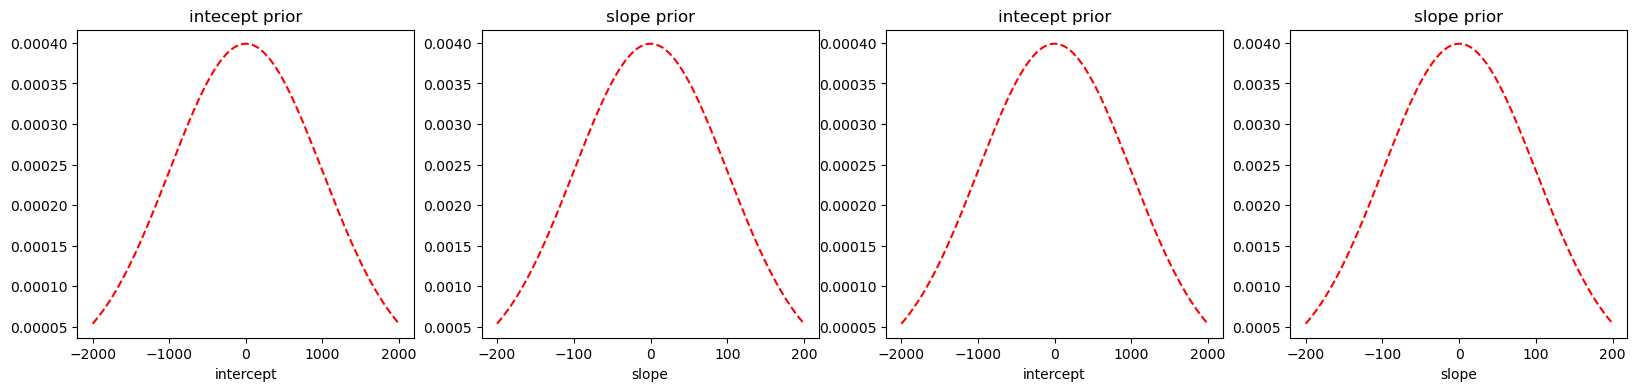

In [23]:
# plot prior (to compare to posterior)
# # TODO with arviz?

plt.figure(figsize=(20,4))

# intercept
plt.subplot(1, 4, 1)
x=np.arange(-2000, 2000)
plt.plot(x, stats.norm(0, 1000).pdf(x), 'r--') # "beta_intercept"
plt.xlabel('intercept')
plt.title('intecept prior');

# slope
plt.subplot(1, 4, 2)
x=np.arange(-200, 200)
plt.plot(x, stats.norm(0, 100).pdf(x), 'r--') # "beta_slope"
plt.xlabel('slope')
plt.title('slope prior');


# additional intercept business days
plt.subplot(1, 4, 3)
x=np.arange(-2000, 2000)
plt.plot(x, stats.norm(0, 1000).pdf(x), 'r--') # "beta_intercept_business_days"
plt.xlabel('intercept')
plt.title('intecept prior');

# interaction
plt.subplot(1, 4, 4)
x=np.arange(-200, 200)
plt.plot(x, stats.norm(0, 100).pdf(x), 'r--') # "beta_slope_interaction"
plt.xlabel('slope')
plt.title('slope prior');

# TODO prior predictive check?
# TODO anschauen, was für eine Datenwolke damit wahrscheinlich ist?
# TODO prior Wahl begründen. Vorwissen beschreiben (eigene Erfahrung, Literatur)

# TODO posterior (und likelihood) dazu malen

TODO vielleicht prior und posterior gemeinsam plotten? Um den Unterschied ("Wissensgewinn") bildlich zu zeigen?

---

TODO
- Posterior predictive check und cross validation: Code aufräumen
- check model assumptions: independence, linear relationship, equal variance/normal distribution, ...
- cross validation... test sets... (mit was vergleicht man das? mit mittlerem Fehler, wenn man immer nur Mittelwert vorhersagen würde?)

##### Posterior predictive check

Median absolute error:  658.6905845158926
Standard deviation of absolute errors:  502.5791767310344
scaled MAE: 0.7495595190375501


,2-5-quant,25-quant,75-quant,97-5-quant,rider_count,point_in_50_pred_int,point_in_95_pred_int
0,718.818728,1942.075225,3194.978674,4376.702285,521,False,False
1,-150.862767,865.124067,1899.716305,2839.491309,1131,True,True
2,-232.316315,739.347056,1775.381595,2781.527369,764,True,True
3,543.775671,1726.500833,3000.380293,4237.417792,1607,False,True
4,458.762806,1676.472679,2938.682939,4099.371104,1668,False,True
...,...,...,...,...,...,...,...
348,478.421844,1459.643796,2481.270563,3453.689616,482,False,True
349,1427.729113,2623.014007,3911.446124,5100.667639,1395,False,False
350,1798.367875,3034.083042,4289.779471,5489.227606,1357,False,False
351,1767.614151,2993.661813,4210.796638,5434.888065,1299,False,False


number of datapoints in 50% prediction interval: 156 percentage of all points: 0.44192634560906513
number of datapoints in 95% prediction interval: 338 percentage of all points: 0.9575070821529745


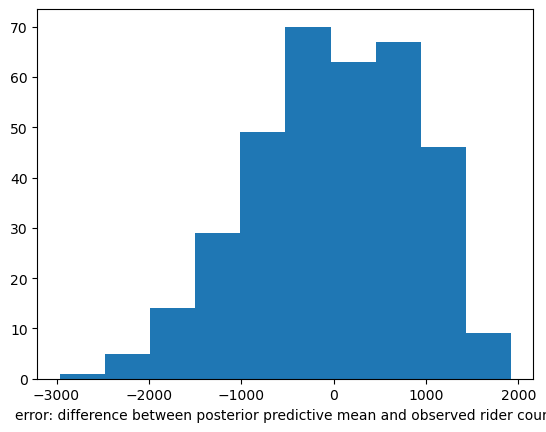

In [24]:
# posterior predictive check
# TODO rewrite as function (because code is used multiple times below)
with linearCategoricalModel:

    # simulate
    ppc = pm.sample_posterior_predictive(trace)
    
    # compute posterior predictive means
    posterior_predicitive_means = ppc['observed'].mean(axis=0) # TODO should be the same as prediction by MAP, right? Because normal distribution...
    # TODO flatten ppc['observed']?

    # compute errors
    errors = combined_daily_dat['rider_count'] - posterior_predicitive_means.flatten()
    plt.hist(errors)
    plt.xlabel('error: difference between posterior predictive mean and observed rider count')

    # compute absolute errors
    absolute_errors = np.abs(errors)
    median_absolute_error = np.median(absolute_errors)
    print('Median absolute error: ', median_absolute_error)
    print('Standard deviation of absolute errors: ', np.std(absolute_errors))

    standard_deviations = ppc['observed'].std(axis=0).flatten() # TODO ddof?
    scaled_MAE = np.median(absolute_errors / standard_deviations) # TODO Stimmt das?
    print('scaled MAE:', scaled_MAE)

    # calculate prediction intervals
    # for each datapoint, calculate 4 quantiles: 2.5%, 25%, 75%, 97.5% --> 95% and 50% prediction interval
    quantiles = np.quantile(ppc['observed'], [0.025, 0.25, 0.75, 0.975], axis=0).T # number of rows = number of datapoints in original dataset, number of columns = 4 = number of computed quantiles

    # convert numpy array to dataframe to make adding of columns and comparison of columns easier
    quants_per_datapoint_df = pd.DataFrame(quantiles[0], columns=['2-5-quant', '25-quant', '75-quant', '97-5-quant'])

    # add original datapoints to df
    quants_per_datapoint_df['rider_count'] = combined_daily_dat['rider_count']

    # check whether points in 50% / 95% prediction interval

    # point in 50% prediction interval?
    # TODO < / > or <=/>= Include equality?
    quants_per_datapoint_df['point_in_50_pred_int'] = ((quants_per_datapoint_df['rider_count'] <= quants_per_datapoint_df['75-quant']) & (quants_per_datapoint_df['rider_count'] >= quants_per_datapoint_df['25-quant']))

    # point in 95% prediction interval?
    # TODO < / > or <=/>= Include equality?
    quants_per_datapoint_df['point_in_95_pred_int'] = ((quants_per_datapoint_df['rider_count'] <= quants_per_datapoint_df['97-5-quant']) & (quants_per_datapoint_df['rider_count'] >= quants_per_datapoint_df['2-5-quant']))
    display(quants_per_datapoint_df)

    print('number of datapoints in 50% prediction interval:', sum(quants_per_datapoint_df['point_in_50_pred_int']), 'percentage of all points:', sum(quants_per_datapoint_df['point_in_50_pred_int'])/ len(quants_per_datapoint_df))
    print('number of datapoints in 95% prediction interval:', sum(quants_per_datapoint_df['point_in_95_pred_int']), 'percentage of all points:', sum(quants_per_datapoint_df['point_in_95_pred_int'])/ len(quants_per_datapoint_df))

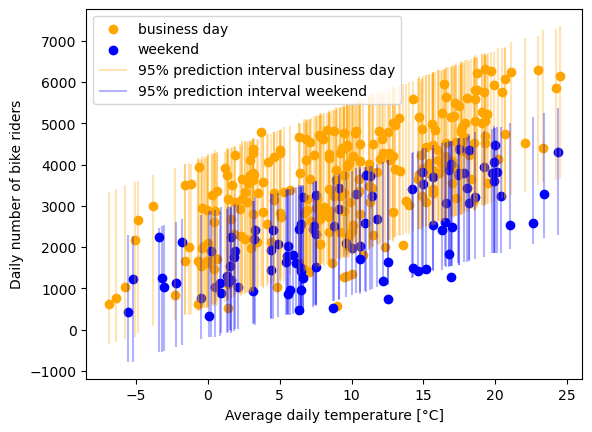

In [25]:
# plot prediction intervals together with original datapoints (should yield same plot as az.plot_hdi below)
# TODO compare to az.plot_hdi below
# TODO rewrite as function (because code is used multiple times below)
with linearCategoricalModel:

    # plot data
    plot_data()

    # indices of business days / non-business days
    busday_indices = combined_daily_dat[combined_daily_dat['is_busday']].index
    nonbusday_indices = combined_daily_dat[~combined_daily_dat['is_busday']].index

    # plot 95% prediction intervals
    plt.vlines(x=combined_daily_dat.iloc[busday_indices]['temperature'], ymin=quants_per_datapoint_df.iloc[busday_indices]['2-5-quant'], ymax=quants_per_datapoint_df.iloc[busday_indices]['97-5-quant'], color='orange', alpha=0.3, label='95% prediction interval business day')
    plt.vlines(x=combined_daily_dat.iloc[nonbusday_indices]['temperature'], ymin=quants_per_datapoint_df.iloc[nonbusday_indices]['2-5-quant'], ymax=quants_per_datapoint_df.iloc[nonbusday_indices]['97-5-quant'], color='blue', alpha=0.3, label='95% prediction interval weekend')
    plt.legend()

preds shape:  (8000, 353)
busday preds shape:  (8000, 253)
nonbusday preds shape:  (8000, 100)
busday temps shape:  (253,)
nonbusday temps shape:  (100,)


/home/maren/anaconda3/envs/data_literacy_project_env/lib/python3.10/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


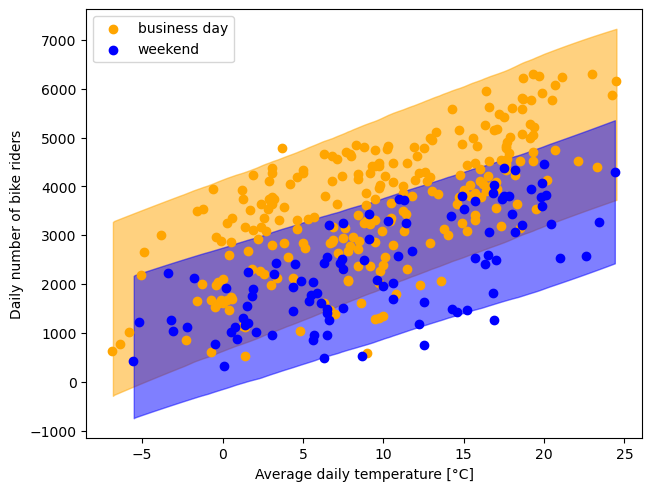

In [26]:
# plot prediction intervals together with original datapoints

# extract predicted bike rider counts (for business days and non-business days)
preds = ppc['observed'][:,:,0]
preds_busdays = preds[:, combined_daily_dat[combined_daily_dat['is_busday']].index]
preds_nonbusdays = preds[:, combined_daily_dat[~combined_daily_dat['is_busday']].index]

# extract temperatures of datapoints (for business days and non-business days)
temps_busdays = combined_daily_dat[combined_daily_dat['is_busday']]['temperature']
temps_nonbusdays = combined_daily_dat[~combined_daily_dat['is_busday']]['temperature']

print('preds shape: ', np.shape(preds))
print('busday preds shape: ', np.shape(preds_busdays))
print('nonbusday preds shape: ', np.shape(preds_nonbusdays))
print('busday temps shape: ', np.shape(temps_busdays))
print('nonbusday temps shape: ', np.shape(temps_nonbusdays))

# plot
# TODO Stimmen HDIs trotzdem? Oder Prozentsatz anpassen, weil es 2 Regression lines sind?
az.plot_hdi(temps_busdays, preds_busdays, color='orange') # TODO label: 'HDI...'
az.plot_hdi(temps_nonbusdays, preds_nonbusdays, color='blue')
plot_data();

TODO

Im Großen und ganzen passt das, oder?
Zum Beispiel:
- variability in Originaldaten ungefähr wie variability in Vorhersagen.
- General positive trend in original and predicted data

Dass etwa 95% der Original-Datenpunkte im 95% Vorhersageintervall liegen, spricht dafür, dass das Modell passt, oder?

Wobei etwa um 5-10°C "Ausschlag nach unten" nicht vorhergesagt wird...

In [27]:
# TODO mit was vergleichen? Fehler, wenn man nur Mittelwert vorhersagt?
print('Median absolute error: ', np.median(np.abs(combined_daily_dat['rider_count'] - np.mean(combined_daily_dat['rider_count']))))
print('standard deviations of absolute errors:', np.std(np.abs(combined_daily_dat['rider_count'] - np.mean(combined_daily_dat['rider_count'])))) # TODO ohne abs?
print('standard deviations of errors:', np.std(combined_daily_dat['rider_count'] - np.mean(combined_daily_dat['rider_count']))) # TODO ohne abs?

Median absolute error:  1034.5750708215296
standard deviations of absolute errors: 765.959278805139
standard deviations of errors: 1362.3631571072099


TODO sind densities (unten unten) anschaulich oder lieber regression lines mit prediction intervals (siehe oben)?

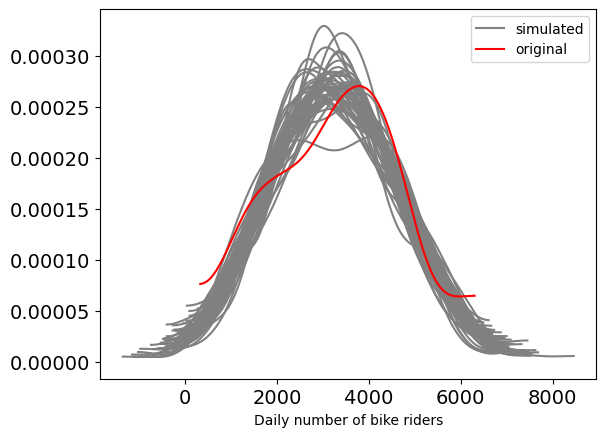

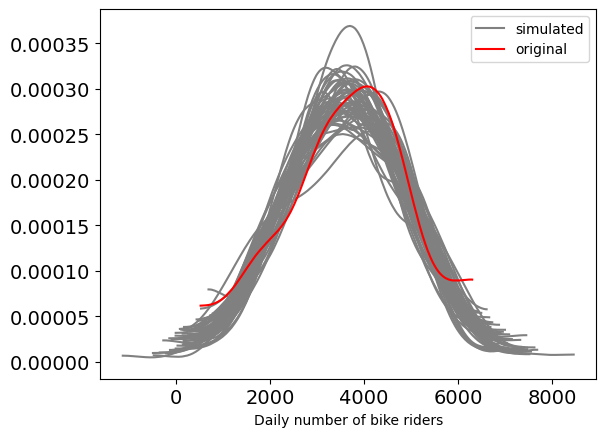

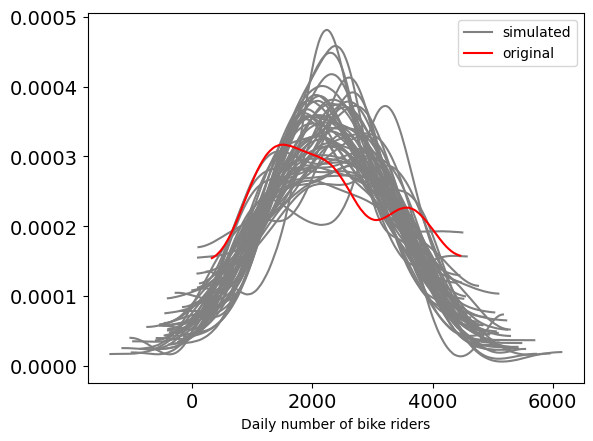

In [28]:
# compare simulated and original data
def compare_sim_to_original(sims, original, xlabel):
    '''
    Parameters
    ----------
    sims : TODO
        simulated bike rider counts
    original : TODO
        original (observed) bike rider counts
    xlabel : str
        x-axis label

    Returns
    -------
    (plot)
    '''
    # initialize figure
    plt.figure()

    # simulated bike rider counts data
    for i in np.arange(50):
        if i==0: # with label
            az.plot_kde(sims[i,:], label='simulated', plot_kwargs={'color': 'grey'})
        else:
            az.plot_kde(sims[i,:], plot_kwargs={'color': 'grey'})

    # original bike rider counts data
    az.plot_kde(original, label='original', plot_kwargs={'color': 'red'})

    # add axis label and legend
    plt.xlabel('Daily number of bike riders')
    plt.legend();

compare_sim_to_original(preds, combined_daily_dat['rider_count'], 'Daily number of bike riders')

# seperated for business days and non-business days
compare_sim_to_original(preds_busdays, combined_daily_dat[combined_daily_dat['is_busday']]['rider_count'], 'Daily number of bike riders on business days')
compare_sim_to_original(preds_nonbusdays, combined_daily_dat[~combined_daily_dat['is_busday']]['rider_count'], 'Daily number of bike riders on non-business days')

##### Cross validation

TODO Beschreibung?

In [29]:
# cross validation
# TODO Code aufräumen

# number of datapoints
n_datapoints = len(combined_daily_dat)

# number of folds
num_folds = 5 # TODO adjust

# determine indices to split data randomly into num_folds parts
indices = np.arange(n_datapoints)
# shuffle
np.random.shuffle(indices)

# number of datapoints in each of the  num_folds part
num_datapoints_per_part = int(np.floor(n_datapoints / num_folds))

# TODO später entfernen
storage_fold_train_data = []
storage_fold_test_data = []

# initialize storage for results
# TODO später einige davon entfernen (brauchen nicht alle)
storage_traces = []
storage_ppcs = []
storage_posterior_predicitive_means = []
storage_AEs = []
storage_MAEs = []
storage_scaledMAEs = []
storage_percent_within_50 = []
storage_percent_within_95 = []

for fold_idx in np.arange(num_folds):

    # TODO später entfernen
    print('fold ' + str(fold_idx))

    # extract train and test data for fold

    # determine indices of train and test data points
    
    start_idx_test_data = fold_idx * num_datapoints_per_part
    end_idx_test_data = (fold_idx + 1) * num_datapoints_per_part

    indices_of_test_data = indices[start_idx_test_data : end_idx_test_data]
    # everything that is not in the test set is in the train set
    indices_of_train_data = np.setxor1d(indices, indices_of_test_data)

    # extract train and test data
    train_data = combined_daily_dat.iloc[indices_of_train_data]
    test_data = combined_daily_dat.iloc[indices_of_test_data]
    test_data.reset_index(drop=True, inplace=True) # TODO für train_data auch machen?

    # store data
    storage_fold_train_data.append(train_data)
    storage_fold_test_data.append(test_data)


    # train the model

    # TODO In Funktion auslagern; ist dasselbe wie oben (vielleicht einfach nur Daten austauschen und neu samplen? Aber dann ist Original-Modell überschrieben)
    # build linear model with categories "business-day vs no-business-day"
    # TODO Gibt das Probleme, weil ich es immer wieder überschreibe?
    with pm.Model() as model:
        
        dat_temps = dat = pm.Data('dat_temps', train_data[['temperature']])
        dat_busday = dat = pm.Data('dat_busday', train_data[['is_busday']])
        dat_rider_counts = dat = pm.Data('dat_rider_counts', train_data[['rider_count']])
        
        # TODO prior anpassen
        # prior for parameters beta
        # idea: same parametrization as in Frequentist analysis above.
        # TODO Keep in mind: Prior should reflect prior knowledge; not expectation.
        beta_intercept = pm.Normal("beta_intercept", mu=0, sigma=1000, shape=1)
        beta_slope = pm.Normal("beta_slope", mu=0, sigma=100, shape=1)
        beta_intercept_business_days = pm.Normal("beta_intercept_business_days", mu=0, sigma=1000, shape=1)
        beta_slope_interaction = pm.Normal("beta_slope_interaction", mu=0, sigma=100, shape=1)
        
        # prior for two noise distributions: better small
        sigma = pm.Exponential("sigma", lam=.01, shape=2)
        
        # the linear model function
        expected = beta_intercept + beta_slope * dat_temps + beta_intercept_business_days * dat_busday + beta_slope_interaction * dat_temps * dat_busday

        noise = sigma[0] * (1 - dat_busday) + sigma[1] * dat_busday
        obs = pm.Normal("observed",
                        mu=expected,
                        sigma=noise,
                        observed=dat_rider_counts)


    # sample
    with model:
        trace = pm.sample(2000, chains=4, tune=3000, target_accept=0.9, return_inferencedata=False)

    # store results
    storage_traces.append(trace)

    # simulate for test set
    with model:

        # change data to test set
        pm.set_data({'dat_temps': test_data[['temperature']]})
        pm.set_data({'dat_busday': test_data[['is_busday']]})
        pm.set_data({'dat_rider_counts': test_data[['rider_count']]}) # TODO eigentlich nicht nötig, oder?

        ppc = pm.sample_posterior_predictive(trace)

        # TODO wird hier das richtige ppc genommen?
        storage_ppcs.append(ppc['observed'])

        # compute posterior predictive means
        posterior_predicitive_means = ppc['observed'].mean(axis=0) # TODO should be the same as prediction by MAP, right? Because normal distribution...
        storage_posterior_predicitive_means.append(posterior_predicitive_means) # TODO maybe append flattened version?

        # compute absolute errors
        absolute_errors = np.abs(test_data['rider_count'] - posterior_predicitive_means.flatten())
        storage_AEs.append(absolute_errors)
        median_absolute_error = np.median(absolute_errors)
        storage_MAEs.append(median_absolute_error)

        # compute scaled absolute errors
        standard_deviations = ppc['observed'].std(axis=0).flatten() # TODO ddof?
        scaled_MAE = np.median(absolute_errors / standard_deviations) # TODO Stimmt das?
        storage_scaledMAEs.append(scaled_MAE)


        # calculate prediction intervals
        # for each datapoint, calculate 4 quantiles: 2.5%, 25%, 75%, 97.5% --> 95% and 50% prediction interval. # TODO Stimmt das?
        quantiles = np.quantile(ppc['observed'], [0.025, 0.25, 0.75, 0.975], axis=0).T # number of rows = number of datapoints in original dataset, number of columns = 4 = number of computed quantiles

        # convert to dataframe to make adding of columns and comparison of columns easier
        quants_per_datapoint_df = pd.DataFrame(quantiles[0], columns=['2-5-quant', '25-quant', '75-quant', '97-5-quant'])

        # add original points to df
        quants_per_datapoint_df['rider_count'] = test_data['rider_count'].values

        # check whether observed bike rider count is within in 50% / 95% prediction interval

        # point in 50% prediction interval?
        # TODO < / > or <=/>= Include equality?
        quants_per_datapoint_df['point_in_50_pred_int'] = ((quants_per_datapoint_df['rider_count'] <= quants_per_datapoint_df['75-quant']) & (quants_per_datapoint_df['rider_count'] >= quants_per_datapoint_df['25-quant']))

        # point in 95% prediction interval?
        # TODO < / > or <=/>= Include equality?
        quants_per_datapoint_df['point_in_95_pred_int'] = ((quants_per_datapoint_df['rider_count'] <= quants_per_datapoint_df['97-5-quant']) & (quants_per_datapoint_df['rider_count'] >= quants_per_datapoint_df['2-5-quant']))

        # compute percentage of original datapoints that lie within prediction interval
        percent_within_50 = sum(quants_per_datapoint_df['point_in_50_pred_int']) / len(quants_per_datapoint_df)
        percent_within_95 = sum(quants_per_datapoint_df['point_in_95_pred_int']) / len(quants_per_datapoint_df)

        storage_percent_within_50.append(percent_within_50)
        storage_percent_within_95.append(percent_within_95)

# results of cross validation:
# TODO auch within model context aufrufen?
print('mean MAE oder all folds:', np.mean(storage_MAEs))
print('mean scaled MAE oder all folds:', np.mean(storage_scaledMAEs))
print('percentage of datapoints within 50% prediction interval:', np.mean(storage_percent_within_50))
print('percentage of datapoints within 95% prediction interval:', np.mean(storage_percent_within_95))

fold 0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_slope_interaction, beta_intercept_business_days, beta_slope, beta_intercept]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 12 seconds.


fold 1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_slope_interaction, beta_intercept_business_days, beta_slope, beta_intercept]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 12 seconds.


fold 2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_slope_interaction, beta_intercept_business_days, beta_slope, beta_intercept]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 13 seconds.


fold 3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_slope_interaction, beta_intercept_business_days, beta_slope, beta_intercept]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 12 seconds.


fold 4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_slope_interaction, beta_intercept_business_days, beta_slope, beta_intercept]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 11 seconds.


mean MAE oder all folds: 666.6594809081606
mean scaled MAE oder all folds: 0.7605108443538022
percentage of datapoints within 50% prediction interval: 0.43714285714285717
percentage of datapoints within 95% prediction interval: 0.9571428571428571


TODO random seeds setzen? Für pm.sample_posterior_predictive...

TODO 95% coverage of 95% prediction interval ist gut, oder? Betrachte neue Daten....

TODO Vergleiche mit weiter oben, wo MAE, prediction interval coverage, ... für den ganzen Datensatz, auf dem trainiert wurde, berechnet wurden.

In [30]:
# TODO mit was vergleicht man das?
# MAE if we would always predict overall mean
print('MAE when predicting mean:', np.median(np.abs(combined_daily_dat['rider_count'] - np.mean(combined_daily_dat['rider_count']))))
print('Standard deviation of absolute errors when predicting mean:', np.std(np.abs(combined_daily_dat['rider_count'] - np.mean(combined_daily_dat['rider_count']))))

MAE when predicting mean: 1034.5750708215296
Standard deviation of absolute errors when predicting mean: 765.959278805139


TODO run the same cross validation with poisson. Compare to model with normal distribution (above).
Or maybe use az.loo oder arviz.compare?

##### Test for another counter site

TODO Also test for another city

In [31]:
# import data
test_data_new_counter_site = pd.read_pickle('./../data/processed/combined_daily_dat.pkl')

# counting station
test_city_name = 'Stadt Freiburg'
test_counter_site = 'FR2 Güterbahn / Ferd.-Weiß-Str.'
test_channel_name = 'FR2 Güterbahn / Ferd.-Weiß-Str.'
#test_channel_ID = 101014511
# TODO use channel_id for identification --> to be able to do so: export also channel_id when building the dataset

# extract data for counting station
test_data_new_counter_site = test_data_new_counter_site[(test_data_new_counter_site.standort == test_city_name) & (test_data_new_counter_site.counter_site == test_counter_site) & (test_data_new_counter_site.channel_name == test_channel_name)]

In [32]:
# check data import
test_data_new_counter_site

,standort,counter_site,channel_name,longitude,latitude,date,temperature,is_busday,rider_count
706,Stadt Freiburg,FR2 Güterbahn / Ferd.-Weiß-Str.,FR2 Güterbahn / Ferd.-Weiß-Str.,7.822082,47.998592,2021-01-01,2.8,True,462
707,Stadt Freiburg,FR2 Güterbahn / Ferd.-Weiß-Str.,FR2 Güterbahn / Ferd.-Weiß-Str.,7.822082,47.998592,2021-01-02,1.8,False,716
708,Stadt Freiburg,FR2 Güterbahn / Ferd.-Weiß-Str.,FR2 Güterbahn / Ferd.-Weiß-Str.,7.822082,47.998592,2021-01-03,0.8,False,556
709,Stadt Freiburg,FR2 Güterbahn / Ferd.-Weiß-Str.,FR2 Güterbahn / Ferd.-Weiß-Str.,7.822082,47.998592,2021-01-04,1.4,True,1397
710,Stadt Freiburg,FR2 Güterbahn / Ferd.-Weiß-Str.,FR2 Güterbahn / Ferd.-Weiß-Str.,7.822082,47.998592,2021-01-05,1.1,True,1401
...,...,...,...,...,...,...,...,...,...
1054,Stadt Freiburg,FR2 Güterbahn / Ferd.-Weiß-Str.,FR2 Güterbahn / Ferd.-Weiß-Str.,7.822082,47.998592,2021-12-26,7.0,False,479
1055,Stadt Freiburg,FR2 Güterbahn / Ferd.-Weiß-Str.,FR2 Güterbahn / Ferd.-Weiß-Str.,7.822082,47.998592,2021-12-27,8.5,True,1265
1056,Stadt Freiburg,FR2 Güterbahn / Ferd.-Weiß-Str.,FR2 Güterbahn / Ferd.-Weiß-Str.,7.822082,47.998592,2021-12-28,11.4,True,1312
1057,Stadt Freiburg,FR2 Güterbahn / Ferd.-Weiß-Str.,FR2 Güterbahn / Ferd.-Weiß-Str.,7.822082,47.998592,2021-12-29,11.1,True,1305


Mean error: -861.8725071070692
Standard deviation of errors: 862.4250571195505
Median absolute error:  876.0279922198552
Standard deviation of absolute errors:  708.3212221034618
scaled MAE: 0.9969431769509549
percentage of datapoints in 50% prediction interval: 0.3314447592067989
percentage of datapoints in 95% prediction interval: 0.8271954674220963


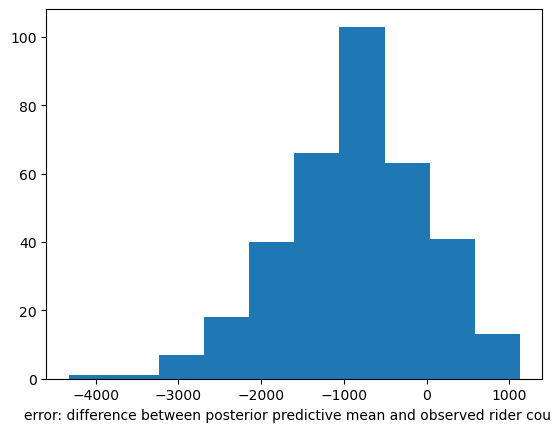

In [33]:
# test model on data of another (new) counter site
with linearCategoricalModel:

    # change data to test set
    pm.set_data({'dat_temps': test_data_new_counter_site[['temperature']]})
    pm.set_data({'dat_busday': test_data_new_counter_site[['is_busday']]})
    pm.set_data({'dat_rider_counts': test_data_new_counter_site[['rider_count']]}) # TODO eigentlich nicht nötig, oder?

    ppc = pm.sample_posterior_predictive(trace)

    # compute posterior predictive means
    posterior_predicitive_means = ppc['observed'].mean(axis=0) # TODO should be the same as prediction by MAP, right? Because normal distribution...

    # compute errors
    errors = test_data_new_counter_site['rider_count'] - posterior_predicitive_means.flatten()
    plt.hist(errors)
    plt.xlabel('error: difference between posterior predictive mean and observed rider count')
    # TODO Ist es sinnvoll, mean error zu berechnen? (Ohne "absolute"?)
    print('Mean error:', np.mean(errors))
    print('Standard deviation of errors:', np.std(errors))

    # compute absolute errors
    absolute_errors = np.abs(errors)
    median_absolute_error = np.median(absolute_errors)
    print('Median absolute error: ', median_absolute_error)
    print('Standard deviation of absolute errors: ', np.std(absolute_errors))

    # compute standard deviations of the predicted data distributions
    standard_deviations = ppc['observed'].std(axis=0).flatten() # TODO ddof?

    # compute scaled MAE
    scaled_MAE = np.median(absolute_errors / standard_deviations) # TODO Stimmt das?
    print('scaled MAE:', scaled_MAE)


    # compute how many test points are within the prediction intervals

    # calculate prediction intervals
    # for each datapoint, calculate 4 quantiles: 2.5%, 25%, 75%, 97.5% --> 95% and 50% prediction interval
    quantiles = np.quantile(ppc['observed'], [0.025, 0.25, 0.75, 0.975], axis=0).T # number of rows = number of datapoints in original dataset, number of columns = 4 = number of computed quantiles

    # convert to dataframe to make adding of columns and comparison of columns easier
    quants_per_datapoint_df = pd.DataFrame(quantiles[0], columns=['2-5-quant', '25-quant', '75-quant', '97-5-quant'])

    # add test points to df
    quants_per_datapoint_df['rider_count'] = test_data_new_counter_site['rider_count'].values

    # check whether observed bike rider count is within in 50% / 95% prediction interval

    # point in 50% prediction interval?
    # TODO < / > or <=/>= Include equality?
    quants_per_datapoint_df['point_in_50_pred_int'] = ((quants_per_datapoint_df['rider_count'] <= quants_per_datapoint_df['75-quant']) & (quants_per_datapoint_df['rider_count'] >= quants_per_datapoint_df['25-quant']))

    # point in 95% prediction interval?
    # TODO < / > or <=/>= Include equality?
    quants_per_datapoint_df['point_in_95_pred_int'] = ((quants_per_datapoint_df['rider_count'] <= quants_per_datapoint_df['97-5-quant']) & (quants_per_datapoint_df['rider_count'] >= quants_per_datapoint_df['2-5-quant']))

    # compute percentage of test datapoints that lie within prediction interval
    percent_within_50 = sum(quants_per_datapoint_df['point_in_50_pred_int']) / len(quants_per_datapoint_df)
    percent_within_95 = sum(quants_per_datapoint_df['point_in_95_pred_int']) / len(quants_per_datapoint_df)

    print('percentage of datapoints in 50% prediction interval:', percent_within_50)
    print('percentage of datapoints in 95% prediction interval:', percent_within_95)

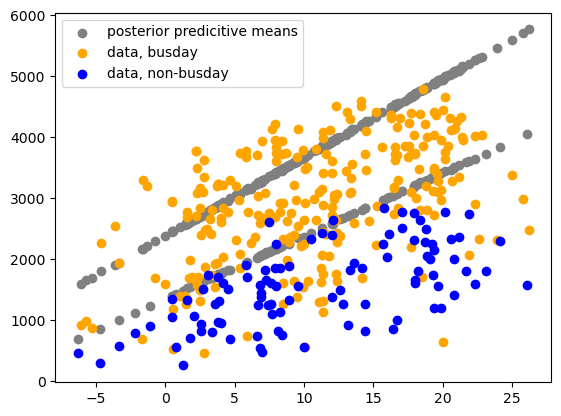

In [34]:
# compare posterior predictive means with actual (observed) test data points
with linearCategoricalModel:
    plt.scatter(test_data_new_counter_site['temperature'], posterior_predicitive_means, label='posterior predicitive means', color='gray') # TODO Heißt das so?
    plt.scatter(test_data_new_counter_site[test_data_new_counter_site['is_busday']]['temperature'], test_data_new_counter_site[test_data_new_counter_site['is_busday']]['rider_count'], label='data, busday', color='orange')
    plt.scatter(test_data_new_counter_site[~test_data_new_counter_site['is_busday']]['temperature'], test_data_new_counter_site[~test_data_new_counter_site['is_busday']]['rider_count'], label='data, non-busday', color='blue')
    plt.legend();
    # TODO add prediction intervals

In [35]:
# TODO mit was vergleicht man das jetzt? Mit Fehler, wenn man einfach Mittelwert vorhersagt?
print('MAE when predicting mean:', np.median(np.abs(test_data_new_counter_site['rider_count'] - np.mean(test_data_new_counter_site['rider_count']))))
print('Standard deviation of absolute errors when predicting mean:', np.std(np.abs(test_data_new_counter_site['rider_count'] - np.mean(test_data_new_counter_site['rider_count']))))
# TODO 890 vs. 842 --> Heißt das, MAE unseres Modells kaum (numerisch) besser als einfach Mittelwert der Daten vorhersagen? (an neuer counting station)?
# TODO und Streuung wäre auch noch kleiner?
# TODO da muss doch was falsch sein, oder? Oder ist Unterschied zwischen den counter sites einfach so groß...
# TODO Vergleiche mit Modell, das extra für diesen Standort gefittet wurde. Das sollte dann schon deutlich besser sein als einfach nur Mittelwert vorhersagen, oder?

MAE when predicting mean: 890.4305949008499
Standard deviation of absolute errors when predicting mean: 578.4014382829621


---

### Poisson Regression: Poisson model with identity link function

TODO  
Reasonable? Might be that lambda-parameter-value of Poisson distribution is <0...  (--> we assume that this is not an issue for our "region of interest" (i.e., from -5°C to 25°C))  
Poisson-Verteilung der Bike-Rider-Counts? Der Residuen?

#### Frequentist

In [36]:
# fit a poisson model with identity link function to the daily bike rider counts data,
# predictors: mean day temperature and being a business day
fit_daily_counts_poisson_identity = smf.glm(
    formula='rider_count ~ temperature * is_busday',
    data=combined_daily_dat,
    family=sm.families.Poisson(link=sm.families.links.identity())).fit()

# check the fit result
print(fit_daily_counts_poisson_identity.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            rider_count   No. Observations:                  353
Model:                            GLM   Df Residuals:                      349
Model Family:                 Poisson   Df Model:                            3
Link Function:               identity   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -52500.
Date:                Sat, 07 Jan 2023   Deviance:                   1.0154e+05
Time:                        15:08:43   Pearson chi2:                 9.37e+04
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

/home/maren/anaconda3/envs/data_literacy_project_env/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Warning refers to: The linear relationship might predict negative parameter values for the Poisson distribution ($X \sim \textit{Poisson}(\lambda)$ which is only defined for $\lambda \ge 0$) - however, we assume that in our "region of interest", this is not a problem.

Main difference to the results with normal distribution: Now, the interaction parameter is also significantly different from 0.

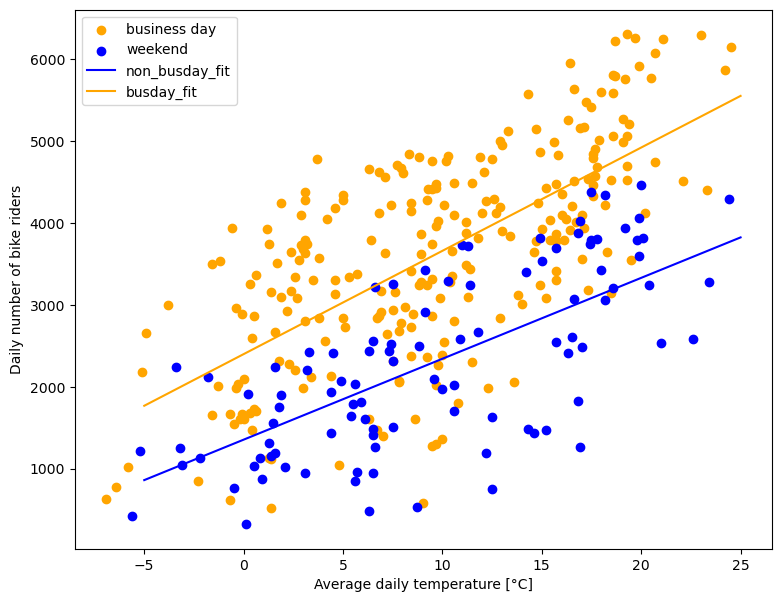

In [37]:
# plot
plt.figure(figsize=(9,7))
plot_data_and_linear_fit(
    fit_daily_counts_poisson_identity.params['Intercept'],
    fit_daily_counts_poisson_identity.params['temperature'],
    fit_daily_counts_poisson_identity.params['is_busday[T.True]'],
    fit_daily_counts_poisson_identity.params['temperature:is_busday[T.True]']
)

##### Check one of the Poisson model assumptions

https://bookdown.org/roback/bookdown-BeyondMLR/ch-poissonreg.html, Table 4.2

Poisson distribution: Expected value equals Variance.

business days:
      mean         var  var/mean     n
0  1712.50  1064665.50    621.70   6.0
1  1976.71  1351917.24    683.92   7.0
2  2499.12   902908.80    361.29  33.0
3  3319.81   726969.56    218.98  31.0
4  3232.63  1071276.48    331.39  35.0
5  3403.35  1153585.97    338.96  46.0
6  4028.44   861547.76    213.87  25.0
7  4434.51   493822.51    111.36  41.0
8  5180.92   838629.21    161.87  24.0
9  5448.80   838144.70    153.82   5.0
non-business days:
      mean         var  var/mean     n
0   821.00   320000.00    389.77   2.0
1  1557.00   330545.50    212.30   5.0
2  1297.79   270923.57    208.76  14.0
3  1794.91   284779.89    158.66  11.0
4  1808.29   732994.47    405.35  17.0
5  2760.54   474758.60    171.98  13.0
6  2153.50  1479625.14    687.08   8.0
7  3102.72   913139.27    294.30  18.0
8  3629.00   323024.25     89.01   9.0
9  3384.33   743470.33    219.68   3.0


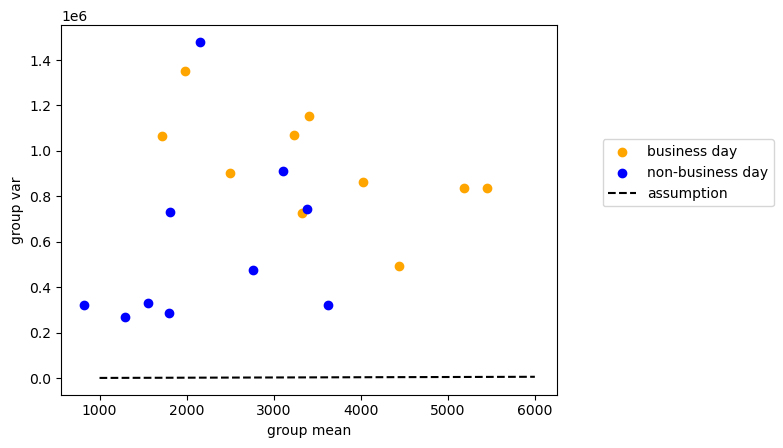

In [38]:
# extraxt data
business_day_data = combined_daily_dat[combined_daily_dat['is_busday'] == True]
non_business_day_data = combined_daily_dat[combined_daily_dat['is_busday'] == False]

# build "artificial" temperature groups and compute mean and variance in each temperature group

# number of groups
n_groups = 10

# boundaries at which to split data into temperature groups
group_boundaries = np.linspace(np.min(combined_daily_dat['temperature']),np.max(combined_daily_dat['temperature']), n_groups + 1)

# initialize storage for results (means, variances, number of datapoints in group)
means_and_var_results_business_days = np.zeros((n_groups, 4))
means_and_var_results_non_business_days = np.zeros((n_groups, 4))

# compute mean and variance in bike rider counts for each temperature group
for i in np.arange(n_groups):
    
    # extract group data
    # TODO Boundaries nur auf einer Seite reinnehmen
    group_data_business_days = business_day_data[(business_day_data['temperature'] >= group_boundaries[i]) & (business_day_data['temperature'] <= group_boundaries[i+1])]
    group_data_non_business_days = non_business_day_data[(non_business_day_data['temperature'] >= group_boundaries[i]) & (non_business_day_data['temperature'] <= group_boundaries[i+1])]
    
    
    # number of datapoints
    means_and_var_results_business_days[i,3] = group_data_business_days.shape[0]
    means_and_var_results_non_business_days[i,3] = group_data_non_business_days.shape[0]
        
    # if at least one datapoint in business day group
    if means_and_var_results_business_days[i,3] > 0:
        
        # mean
        means_and_var_results_business_days[i,0] = group_data_business_days['rider_count'].mean()
        
        # var # TODO sinnvoll bei einem Datenpunkt?
        means_and_var_results_business_days[i,1] = group_data_business_days['rider_count'].var(ddof=1) # TODO ddof?
        
        means_and_var_results_business_days[i,2] = means_and_var_results_business_days[i,1] / means_and_var_results_business_days[i,0] # TODO avoid division by 0

    # if at least one datapoint in non-business day group
    if means_and_var_results_business_days[i,3] > 0:
        
        # mean
        means_and_var_results_non_business_days[i,0] = group_data_non_business_days['rider_count'].mean()
        
        # var # TODO sinnvoll bei einem Datenpunkt?
        means_and_var_results_non_business_days[i,1] = group_data_non_business_days['rider_count'].var(ddof=1) # TODO ddof?
        
        means_and_var_results_non_business_days[i,2] = means_and_var_results_non_business_days[i,1] / means_and_var_results_non_business_days[i,0] # TODO avoid division by 0


plt.scatter(means_and_var_results_business_days[:,0], means_and_var_results_business_days[:,1], color='orange', label='business day')
plt.scatter(means_and_var_results_non_business_days[:,0], means_and_var_results_non_business_days[:,1], color='blue', label='non-business day')


# Poisson distribution assumption
plt.plot([1000., 6000.], [1000., 6000.], '--', color='black', label='assumption')

plt.xlabel('group mean')
plt.ylabel('group var')
plt.legend(bbox_to_anchor = (1.45, 0.6), loc='center right');

# print
print('business days:')
print(pd.DataFrame(np.round(means_and_var_results_business_days,2), columns = ['mean','var', 'var/mean', 'n']))
print('non-business days:')
print(pd.DataFrame(np.round(means_and_var_results_non_business_days,2), columns = ['mean','var', 'var/mean', 'n']))

TODO  
means und variances entsprechen sich überhaupt nicht. Also: Annahme für Poisson-Regression nicht erfüllt.

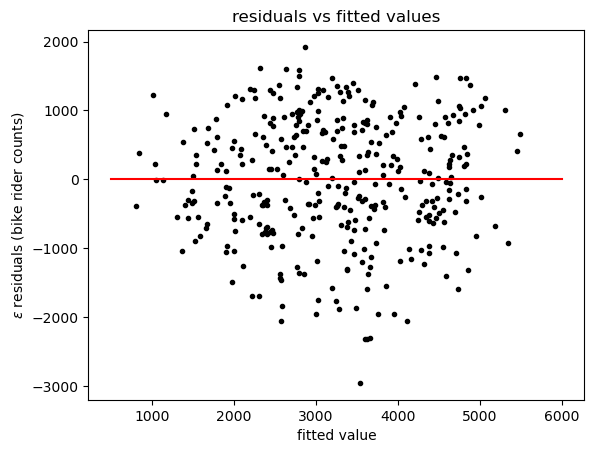

In [39]:
# TODO inspect residuals
plt.plot(fit_daily_counts_poisson_identity.predict(combined_daily_dat), fit_daily_counts_poisson_identity.resid_response, 'k.')
plt.plot([500, 6000], 2*[0], 'r-')
plt.xlabel('fitted value')
plt.ylabel('$\epsilon$ residuals (bike rider counts)')
plt.title('residuals vs fitted values');

For Poisson distribution, the variance in residuals should get larger as the fitted value increases.

#### Bayes

In [40]:
# build linear poisson (TODO wie heißt das jetzt?) model with categories "business-day vs no-business-day"

with pm.Model() as linearPoissonModel:
    
    # TODO prior anpassen
    # TODO Aktuell priors hier etwas anders gesetzt als oben bei Gaussian, um Startbedingungen zu finden,
    # für die der Sampler durchläuft... (kein Problem mit Poisson-Parameter < 0 auftritt)...
    # prior for parameter vector beta
    # TODO Keep in mind: Prior should reflect prior knowledge; not expectation.
    beta_intercept = pm.Normal("beta_intercept", mu=1000, sigma=1000, shape=1)
    beta_slope = pm.Normal("beta_slope", mu=50, sigma=10, shape=1)
    beta_intercept_business_days = pm.Normal("beta_intercept_business_days", mu=0, sigma=1000, shape=1)
    beta_slope_interaction = pm.Normal("beta_slope_interaction", mu=0, sigma=100, shape=1)
    
    # the linear model function
    expected = beta_intercept + beta_slope * combined_daily_dat['temperature'] + beta_intercept_business_days * combined_daily_dat['is_busday'] + beta_slope_interaction * combined_daily_dat['temperature'] * combined_daily_dat['is_busday']
    # TODO hier vielleicht noch sicherstellen, dass es >= 0 ist? Für Poisson...
    
    # Poisson likelihood
    obs = pm.Poisson("observed",
                    mu=expected,
                    observed=combined_daily_dat['rider_count'])
    
# sample
with linearPoissonModel:
    trace = pm.sample(2000, chains=4, tune=3000, target_accept=0.9, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_slope_interaction, beta_intercept_business_days, beta_slope, beta_intercept]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 6 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_intercept[0],1356.004,6.006,1344.005,1367.523,0.119,0.084,2563.0,3546.0,1.0
beta_slope[0],98.651,0.588,97.523,99.782,0.012,0.008,2505.0,3253.0,1.0
beta_intercept_business_days[0],1043.702,8.194,1028.740,1060.561,0.160,0.113,2614.0,3474.0,1.0
beta_slope_interaction[0],27.503,0.789,25.985,29.037,0.016,0.011,2487.0,3660.0,1.0


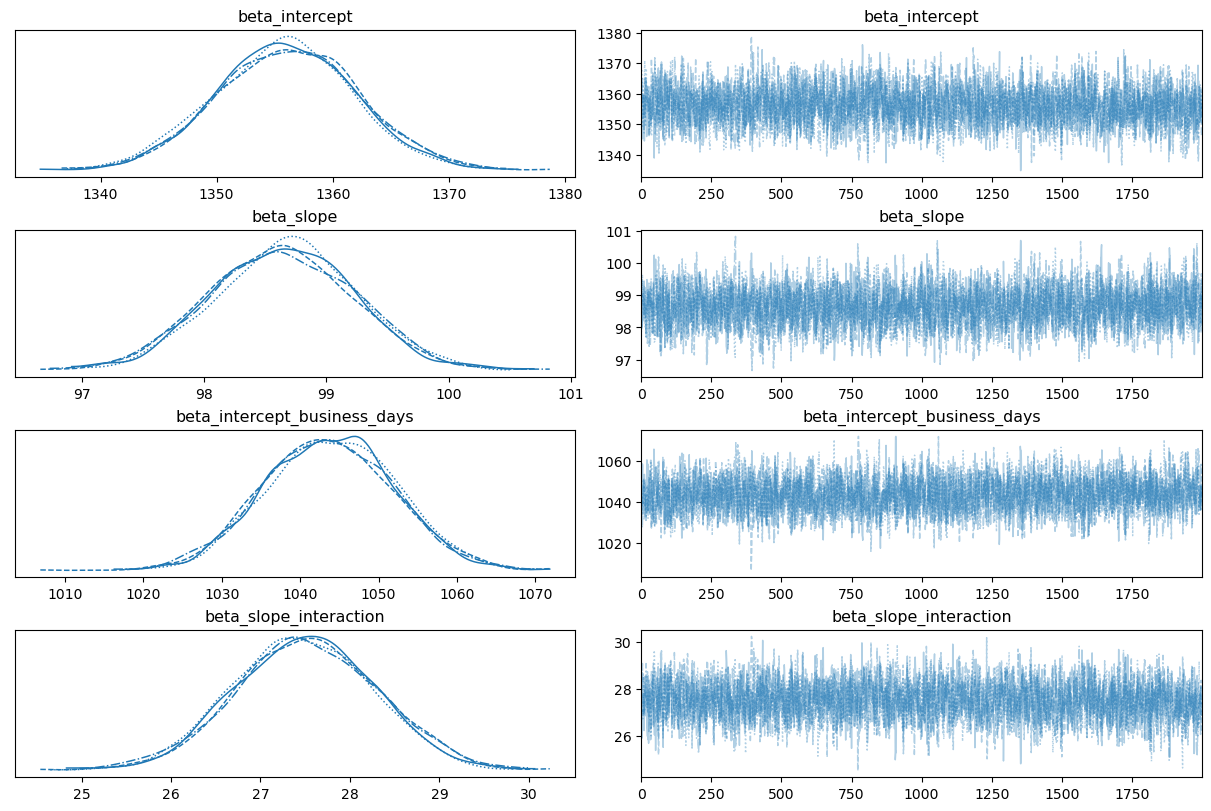

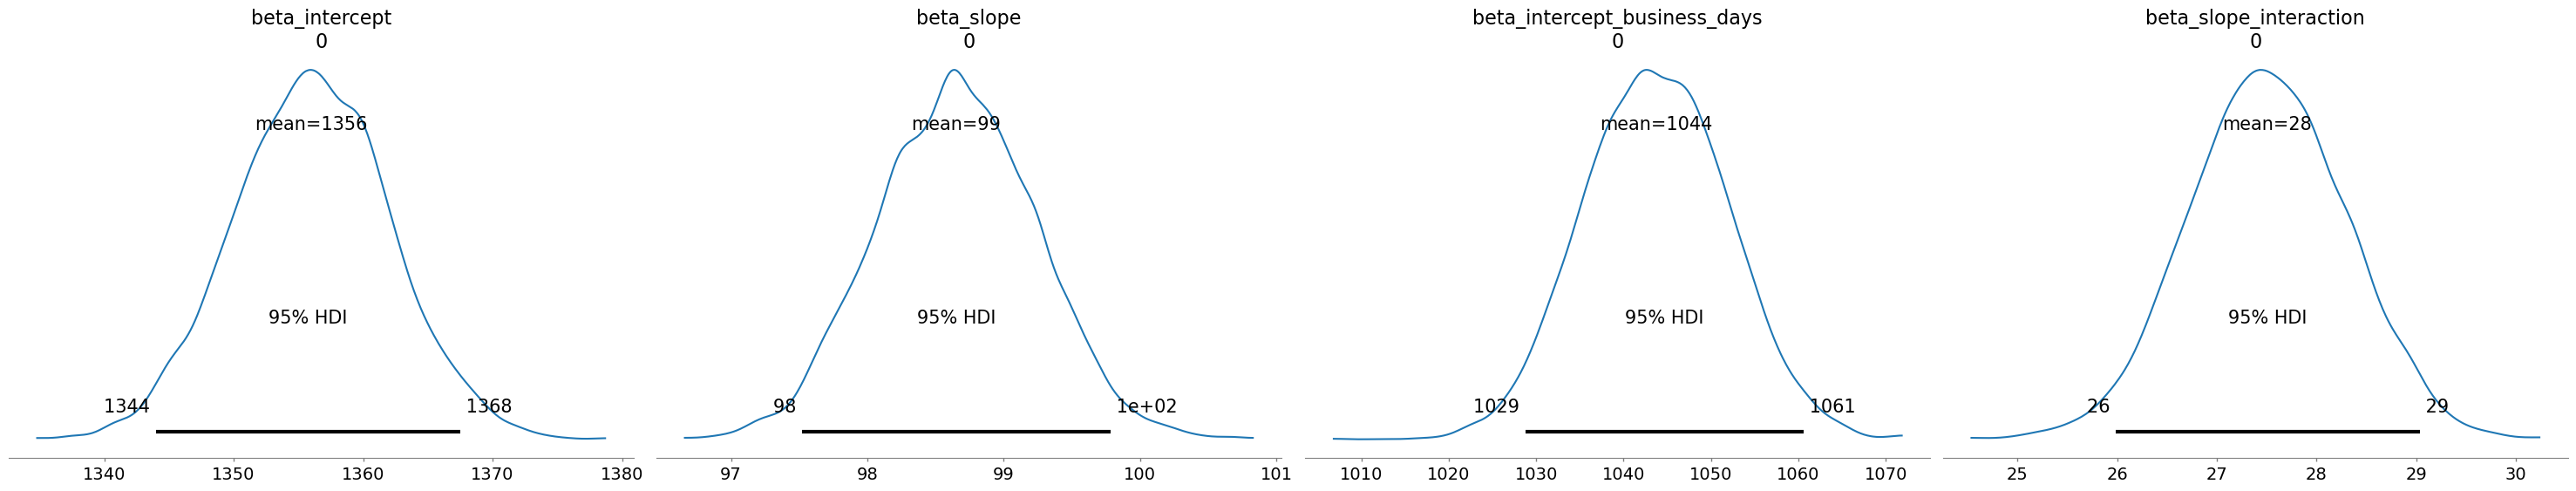

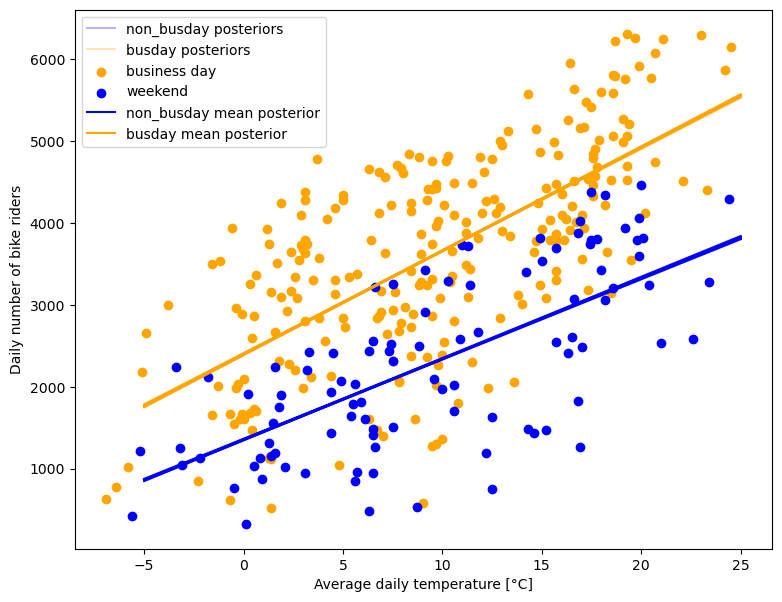

In [41]:
# print / plot the fit results
show_results_linear_fit(linearPoissonModel)

##### Posterior predictive check

Median absolute error:  672.6927500000002
Standard deviation of absolute errors:  501.92987213510634
scaled MAE: 12.242077156867971


,2-5-quant,25-quant,75-quant,97-5-quant,rider_count,point_in_50_pred_int,point_in_95_pred_int
0,2475.000,2541.0,2610.0,2676.025,521,False,False
1,1360.975,1410.0,1462.0,1510.000,1131,False,False
2,1235.000,1281.0,1330.0,1376.000,764,False,False
3,2306.000,2366.0,2433.0,2497.000,1607,False,False
4,2216.000,2278.0,2344.0,2405.000,1668,False,False
...,...,...,...,...,...,...,...
348,1890.000,1947.0,2007.0,2065.000,482,False,False
349,3169.000,3243.0,3320.0,3396.000,1395,False,False
350,3544.000,3621.0,3702.0,3783.000,1357,False,False
351,3505.000,3582.0,3664.0,3744.000,1299,False,False


number of datapoints in 50% prediction interval: 9 percentage of all points: 0.025495750708215296
number of datapoints in 95% prediction interval: 25 percentage of all points: 0.0708215297450425


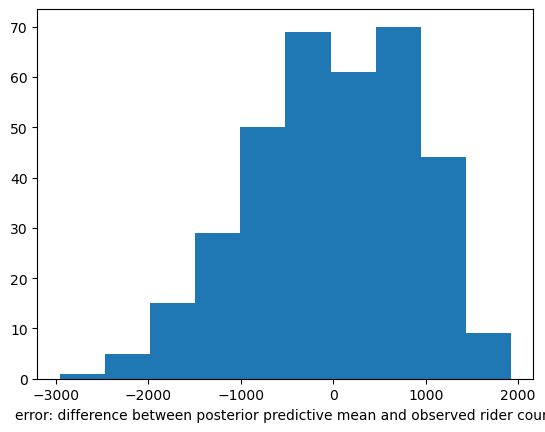

In [42]:
# posterior predictive check
with linearPoissonModel:

    ppc = pm.sample_posterior_predictive(trace)

    # compute posterior predictive means
    posterior_predicitive_means = ppc['observed'].mean(axis=0)
    # TODO flatten ppc['observed']?

    # compute errors
    errors = combined_daily_dat['rider_count'] - posterior_predicitive_means.flatten()
    plt.hist(errors)
    plt.xlabel('error: difference between posterior predictive mean and observed rider count')

    # compute absolute errors
    absolute_errors = np.abs(errors)
    median_absolute_error = np.median(absolute_errors)
    print('Median absolute error: ', median_absolute_error)
    print('Standard deviation of absolute errors: ', np.std(absolute_errors))

    # compute scaled MAE
    standard_deviations = ppc['observed'].std(axis=0).flatten() # TODO ddof?
    scaled_MAE = np.median(absolute_errors / standard_deviations) # TODO Stimmt das?
    print('scaled MAE:', scaled_MAE)

    # calculate prediction intervals
    # for each datapoint, calculate 4 quantiles: 2.5%, 25%, 75%, 97.5% --> 95% and 50% prediction interval
    quantiles = np.quantile(ppc['observed'], [0.025, 0.25, 0.75, 0.975], axis=0).T # number of rows = number of datapoints in original dataset, number of columns = 4 = number of computed quantiles

    # convert to dataframe to make adding of columns and comparison of columns easier
    quants_per_datapoint_df = pd.DataFrame(quantiles, columns=['2-5-quant', '25-quant', '75-quant', '97-5-quant'])

    # add original points to df
    quants_per_datapoint_df['rider_count'] = combined_daily_dat['rider_count']

    # check whether points in 50% / 95% prediction interval

    # point in 50% prediction interval?
    # TODO < / > or <=/>= Include equality?
    quants_per_datapoint_df['point_in_50_pred_int'] = ((quants_per_datapoint_df['rider_count'] <= quants_per_datapoint_df['75-quant']) & (quants_per_datapoint_df['rider_count'] >= quants_per_datapoint_df['25-quant']))

    # point in 95% prediction interval?
    # TODO < / > or <=/>= Include equality?
    quants_per_datapoint_df['point_in_95_pred_int'] = ((quants_per_datapoint_df['rider_count'] <= quants_per_datapoint_df['97-5-quant']) & (quants_per_datapoint_df['rider_count'] >= quants_per_datapoint_df['2-5-quant']))
    display(quants_per_datapoint_df)

    print('number of datapoints in 50% prediction interval:', sum(quants_per_datapoint_df['point_in_50_pred_int']), 'percentage of all points:', sum(quants_per_datapoint_df['point_in_50_pred_int'])/ len(quants_per_datapoint_df))
    print('number of datapoints in 95% prediction interval:', sum(quants_per_datapoint_df['point_in_95_pred_int']), 'percentage of all points:', sum(quants_per_datapoint_df['point_in_95_pred_int'])/ len(quants_per_datapoint_df))

TODO --> coverage ist miserabel. Model passt vermutlich nicht.

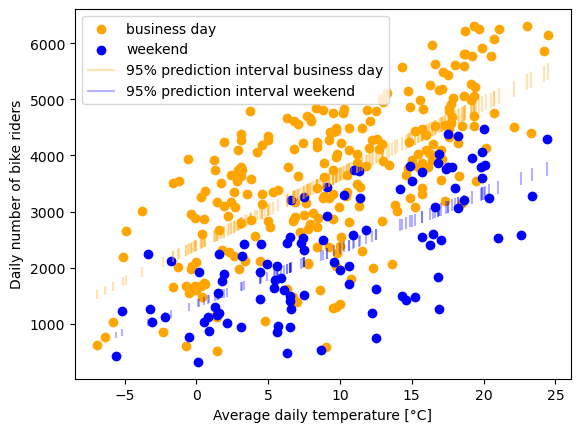

In [43]:
# plot prediction intervals together with original datapoint
with linearPoissonModel:

    # plot data
    plot_data()

    # indices of business days / non-business days
    busday_indices = combined_daily_dat[combined_daily_dat['is_busday']].index
    nonbusday_indices = combined_daily_dat[~combined_daily_dat['is_busday']].index

    # plot 95% prediction intervals
    plt.vlines(x=combined_daily_dat.iloc[busday_indices]['temperature'], ymin=quants_per_datapoint_df.iloc[busday_indices]['2-5-quant'], ymax=quants_per_datapoint_df.iloc[busday_indices]['97-5-quant'], color='orange', alpha=0.3, label='95% prediction interval business day')
    plt.vlines(x=combined_daily_dat.iloc[nonbusday_indices]['temperature'], ymin=quants_per_datapoint_df.iloc[nonbusday_indices]['2-5-quant'], ymax=quants_per_datapoint_df.iloc[nonbusday_indices]['97-5-quant'], color='blue', alpha=0.3, label='95% prediction interval weekend')

    plt.legend()

TODO prediction viel zu wenig Varianz, oder? Data overdispersed?

### Bootstrapping

To avoid issues with distribution assumptions.

See also: https://towardsdatascience.com/linear-regression-with-bootstrapping-4924c05d2a9

In [44]:
# number of simulated experiments/datasets
B = 1000 # TODO increase

# number of samples per dataset
samples_per_dataset = combined_daily_dat.shape[0]

# initialize storage for results
results = np.zeros((B, 4))

# simulate B datasets and fit model to each of them 
for b in np.arange(B):
    
    # simulate dataset
    dat = combined_daily_dat.sample(n=samples_per_dataset, replace=True, axis=0)
    
    # fit model
    bootstrap_fit_daily_counts_ols = smf.ols(formula="rider_count ~ temperature * is_busday", data=dat).fit()
    
    # extract parameters and store them
    results[b, 0] = bootstrap_fit_daily_counts_ols.params['Intercept']
    results[b, 1] = bootstrap_fit_daily_counts_ols.params['temperature']
    results[b, 2] = bootstrap_fit_daily_counts_ols.params['is_busday[T.True]']
    results[b, 3] = bootstrap_fit_daily_counts_ols.params['temperature:is_busday[T.True]']

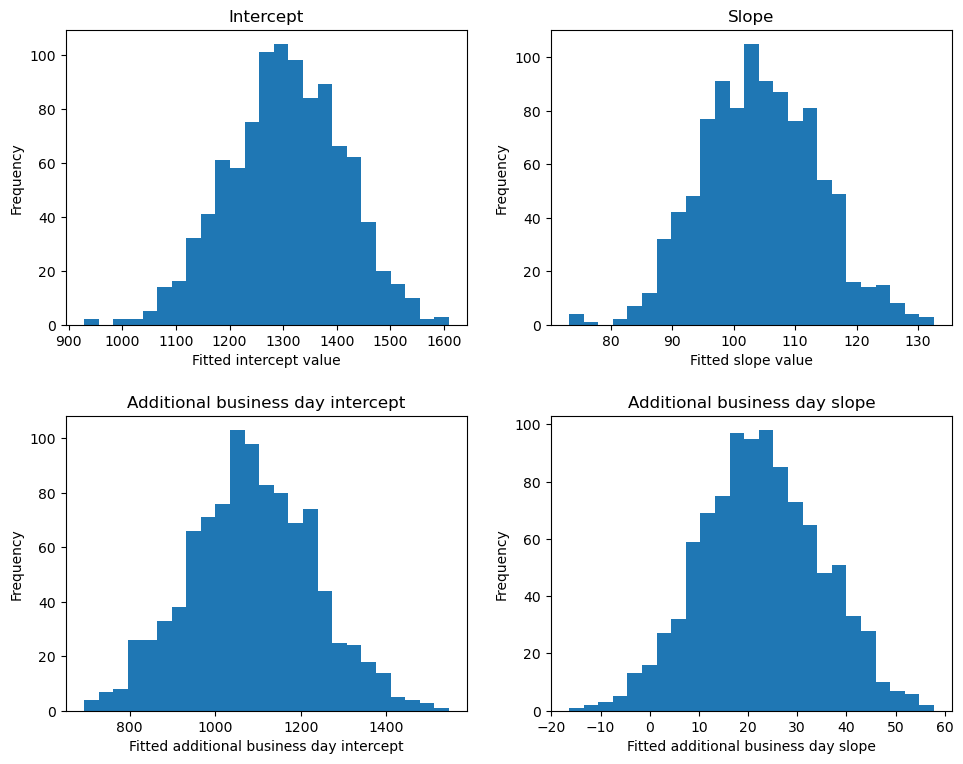

In [45]:
# plot bootstrapped results # TODO Wie nennt man das?

f = plt.figure(figsize=(10,8))

nbins=25

# intercept
ax = f.add_subplot(221)
ax.hist(results[:, 0], bins=nbins)
plt.xlabel('Fitted intercept value')
plt.ylabel('Frequency')
plt.title('Intercept');

# slope
ax = f.add_subplot(222)
ax.hist(results[:, 1], bins=nbins)
plt.xlabel('Fitted slope value')
plt.ylabel('Frequency')
plt.title('Slope');

# additional business day intercept
ax = f.add_subplot(223)
ax.hist(results[:, 2], bins=nbins)
plt.xlabel('Fitted additional business day intercept')
plt.ylabel('Frequency')
plt.title('Additional business day intercept');

# additional business day slope
ax = f.add_subplot(224)
ax.hist(results[:, 3], bins=nbins)
plt.xlabel('Fitted additional business day slope')
plt.ylabel('Frequency')
plt.title('Additional business day slope')

f.tight_layout(pad=2);

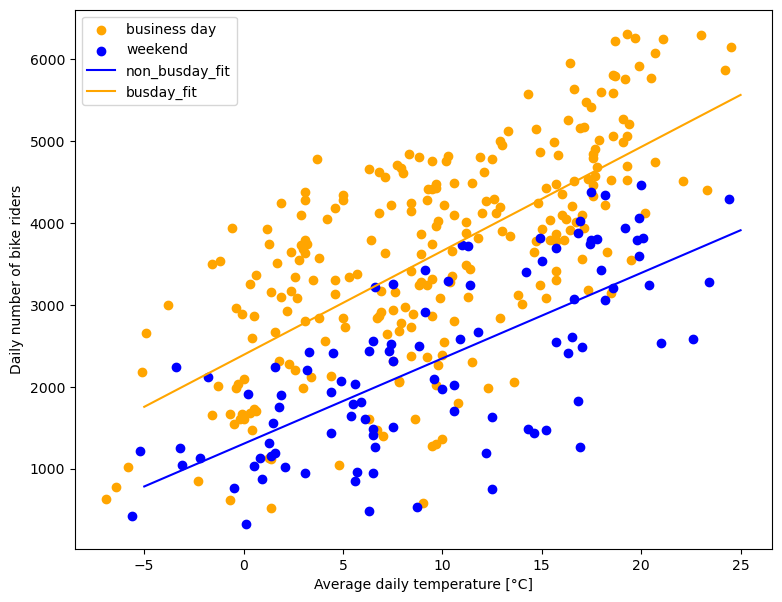

In [46]:
plt.figure(figsize=(9,7))
plot_data_and_linear_fit(
    results[:, 0].mean(),
    results[:, 1].mean(),
    results[:, 2].mean(),
    results[:, 3].mean()
)

# TODO Stimmt das, dass die means unsere estimates sind?
# TODO Oder vergleicht man ersten Fit an Daten mit Bootstrap-Verteilung?

---
TODO  
Notes:

Possible shortcomings of our analyis method / model:  

- linear model: maybe yields predictions < 0 (--> we assume that this is not an issue for our "region of interest" (i.e., from -5°C to 25°C))
- Normal distribution? --> maybe yields predictions that are not integers.
- Poisson for count data would be good. But: Assumption is violated: Mean $\neq$ Variance

To think about:  
Sind unsere Datenpunkte unabhängig voneinander? Wenn ich Fahrrad schonmal in Keller gebracht habe (für Winter), hole ich es vielleicht auch nicht mehr raus, auch wenn es nochmal wärmer werden sollte...